In [6]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina' # I use a HiDPI screen
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

In [18]:
premades = pickle.load((open("../data/premades.p", "rb")) )
import copy

# copy the S3 lensing
planck_lensing = copy.deepcopy(premades['S3'][-1])

# the things that matter are k_min, k_max, f_sky, and noise_k
planck_lensing.k_min = 80
planck_lensing.k_max = 2500
planck_lensing.f_sky = 0.65
planck_lensing.noise_k = np.genfromtxt('/Users/juliexue/Desktop/fishchips/notebooks/planck_noise_k.txt', skip_footer=1)

In [19]:
par = np.array( ['sigma_dmeff'])
ls_of_mass = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
center = np.array([1e-25])
step = np.array([1e-25])

obs_sigmap = Observables(parameters=par,
                  fiducial=center,
                  left=center-step,
                  right=center+step)

# Different Experiments
Planck_assumption = CMB_Primary(
    theta_fwhm=[14,10,7.,5.,5.], sigma_T=[137,65.,43.,66.,200], sigma_P=[450,103.,81.,134.,406],
    f_sky=0.6, l_min=2, l_max=2500)
CMBS4_assumption = CMB_Primary(
    theta_fwhm=[1.5], sigma_T=[1.0], sigma_P=[1.0],
    f_sky=0.4, l_min=300, l_max=2500)
SO_assumption = CMB_Primary(
    theta_fwhm=[1.4], sigma_T=[6.3], sigma_P=[6.3],
    f_sky=0.4, l_min=2, l_max=2500)

In [20]:
# function for Planck lensing
def get_1_sigma_planck_lensing(mass_dm_particle, model_n, center_n, step_n):   
    par_model = np.array(['sigma_dmeff'])
    center_model = np.array([center_n])
    step_model = np.array([step_n])
    obs_sigmap_n = Observables(parameters=par_model,
                  fiducial=center_model,
                  left=center_model-step_model,
                  right=center_model+step_model)
    classy_template_masses_n = {'omega_cdm':1e-15,
                   'omega_dmeff':0.120,
                   'm_dmeff':mass_dm_particle,
                   'npow_dmeff':model_n,
                   'Vrel_dmeff':0,
                   'dmeff_target': 'baryons',
                   'output': 'tCl pCl lCl',
                   'l_max_scalars': 5000,
                   'lensing': 'y' }
    classy_template_masses_n.update(dict(zip(obs_sigmap_n.parameters, obs_sigmap_n.fiducial)))
    obs_sigmap_n.compute_cosmo(key='fiducial', classy_dict=classy_template_masses_n)
    for par, par_left, par_right in zip(obs_sigmap_n.parameters, obs_sigmap_n.left, obs_sigmap_n.right):
        classy_left_m = classy_template_masses_n.copy()
        classy_left_m[par] = par_left
        classy_right_m = classy_template_masses_n.copy()
        classy_right_m[par] = par_right
        obs_sigmap_n.compute_cosmo(key=par + '_left', classy_dict=classy_left_m)
        obs_sigmap_n.compute_cosmo(key=par + '_right', classy_dict=classy_right_m)
    masses_fisher = []
    masses_fisher_lensing = []
    masses_fisher_primary = []
    masses_fisher_lensing = planck_lensing.get_fisher(obs_sigmap_n, lensed_Cl=True)[0][0]
    masses_fisher_primary = np.sum([exp.get_fisher(obs_sigmap_n, lensed_Cl=True)
                  for exp in planck_lensing], axis=0)[0][0]
    masses_fisher = np.sum(masses_fisher_primary, masses_fisher_lensing)
    one_sigma = 2*(1/masses_fisher)**(1/2)
    return one_sigma

In [21]:
# n = 0 model plots for Planck with and without lensing

Planck_masses_inv = []

Planck_masses_inv.append(get_1_sigma_planck_lensing(1e-5, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma_planck_lensing(1e-4, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma_planck_lensing(1e-3, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma_planck_lensing(1e-2, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma_planck_lensing(1e-1, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma_planck_lensing(1, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma_planck_lensing(10, 0, 1e-24, 1e-24))
Planck_masses_inv.append(get_1_sigma_planck_lensing(100, 0, 1e-22, 1e-22))
Planck_masses_inv.append(get_1_sigma_planck_lensing(1000, 0, 1e-22, 1e-22))

Planck_masses_inv_linear = []

Planck_masses_inv_linear.append(get_1_sigma_linear(1e-5, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-4, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-3, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-2, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-1, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(10, Planck_assumption, 0, 1e-24, 1e-24))
Planck_masses_inv_linear.append(get_1_sigma_linear(100, Planck_assumption, 0, 1e-22, 1e-22))
Planck_masses_inv_linear.append(get_1_sigma_linear(1000, Planck_assumption, 0, 1e-22, 1e-22))

ValueError: setting an array element with a sequence.

In [4]:
def get_1_sigma_linear(mass_dm_particle, experiment_assumption, model_n, center_n, step_n):   
    par_model = np.array(['sigma_dmeff'])
    center_model = np.array([center_n])
    step_model = np.array([step_n])
    obs_sigmap_n = Observables(parameters=par_model,
                  fiducial=center_model,
                  left=center_model-step_model,
                  right=center_model+step_model)
    classy_template_masses_n = {'omega_cdm':1e-15,
                   'omega_dmeff':0.120,
                   'm_dmeff':mass_dm_particle,
                   'npow_dmeff':model_n,
                   'Vrel_dmeff':0,
                   'dmeff_target': 'baryons',
                   'output': 'tCl pCl lCl',
                   'l_max_scalars': 2500,
                   'lensing': 'nah' }
    classy_template_masses_n.update(dict(zip(obs_sigmap_n.parameters, obs_sigmap_n.fiducial)))
    obs_sigmap_n.compute_cosmo(key='fiducial', classy_dict=classy_template_masses_n)
    for par, par_left, par_right in zip(obs_sigmap_n.parameters, obs_sigmap_n.left, obs_sigmap_n.right):
        classy_left_m = classy_template_masses_n.copy()
        classy_left_m[par] = par_left
        classy_right_m = classy_template_masses_n.copy()
        classy_right_m[par] = par_right
        obs_sigmap_n.compute_cosmo(key=par + '_left', classy_dict=classy_left_m)
        obs_sigmap_n.compute_cosmo(key=par + '_right', classy_dict=classy_right_m)
    masses_fisher = []
#   masses_fisher = np.sum([exp.get_fisher(obs_sigmap_n, lensed_Cl=True)
#                for exp in premades[experiment_assumption]], axis=0 )[0][0]
    masses_fisher = experiment_assumption.get_fisher(obs_sigmap_n,lensed_Cl=False)[0][0]
    one_sigma = 2*(1/masses_fisher)**(1/2)
    return one_sigma

def get_1_sigma(mass_dm_particle, experiment_assumption, model_n, center_n, step_n):   
    par_model = np.array(['sigma_dmeff'])
    center_model = np.array([center_n])
    step_model = np.array([step_n])
    obs_sigmap_n = Observables(parameters=par_model,
                  fiducial=center_model,
                  left=center_model-step_model,
                  right=center_model+step_model)
    classy_template_masses_n = {'omega_cdm':1e-15,
                   'omega_dmeff':0.120,
                   'm_dmeff':mass_dm_particle,
                   'npow_dmeff':model_n,
                   'Vrel_dmeff':0,
                   'dmeff_target': 'baryons',
                   'output': 'tCl pCl lCl',
                   'l_max_scalars': 5000,
                   'lensing': 'y' }
    classy_template_masses_n.update(dict(zip(obs_sigmap_n.parameters, obs_sigmap_n.fiducial)))
    obs_sigmap_n.compute_cosmo(key='fiducial', classy_dict=classy_template_masses_n)
    for par, par_left, par_right in zip(obs_sigmap_n.parameters, obs_sigmap_n.left, obs_sigmap_n.right):
        classy_left_m = classy_template_masses_n.copy()
        classy_left_m[par] = par_left
        classy_right_m = classy_template_masses_n.copy()
        classy_right_m[par] = par_right
        obs_sigmap_n.compute_cosmo(key=par + '_left', classy_dict=classy_left_m)
        obs_sigmap_n.compute_cosmo(key=par + '_right', classy_dict=classy_right_m)
    masses_fisher = []
    masses_fisher = np.sum([exp.get_fisher(obs_sigmap_n, lensed_Cl=True)
                  for exp in premades[experiment_assumption]], axis=0)[0][0]
#    masses_fisher = experiment_assumption.get_fisher(obs_sigmap)[0][0]
    one_sigma = 2*(1/masses_fisher)**(1/2)
    return one_sigma

In [5]:
# n = 0 model plots for Planck with and without lensing, SO Primary, and CMB-S3 and -S4 with lensing
Planck_masses_inv = []

Planck_masses_inv.append(get_1_sigma(1e-5, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma(1e-4, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma(1e-3, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma(1e-2, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma(1e-1, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma(1, 0, 1e-25, 1e-25))
Planck_masses_inv.append(get_1_sigma(10, 0, 1e-24, 1e-24))
Planck_masses_inv.append(get_1_sigma(100, 0, 1e-22, 1e-22))
Planck_masses_inv.append(get_1_sigma(1000, 0, 1e-22, 1e-22))

Planck_masses_inv_linear = []

Planck_masses_inv_linear.append(get_1_sigma_linear(1e-5, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-4, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-3, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-2, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1e-1, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(1, Planck_assumption, 0, 1e-25, 1e-25))
Planck_masses_inv_linear.append(get_1_sigma_linear(10, Planck_assumption, 0, 1e-24, 1e-24))
Planck_masses_inv_linear.append(get_1_sigma_linear(100, Planck_assumption, 0, 1e-22, 1e-22))
Planck_masses_inv_linear.append(get_1_sigma_linear(1000, Planck_assumption, 0, 1e-22, 1e-22))

TypeError: get_1_sigma() missing 1 required positional argument: 'step_n'

In [6]:
CMBS3_masses_inv = []

CMBS3_masses_inv.append(get_1_sigma(1e-5, "S3", 0, 1e-25, 1e-25))
CMBS3_masses_inv.append(get_1_sigma(1e-4, "S3", 0, 1e-25, 1e-25))
CMBS3_masses_inv.append(get_1_sigma(1e-3, "S3", 0, 1e-25, 1e-25))
CMBS3_masses_inv.append(get_1_sigma(1e-2, "S3", 0, 1e-25, 1e-25))
CMBS3_masses_inv.append(get_1_sigma(1e-1, "S3", 0, 1e-25, 1e-25))
CMBS3_masses_inv.append(get_1_sigma(1, "S3", 0, 1e-25, 1e-25))
CMBS3_masses_inv.append(get_1_sigma(10, "S3", 0, 1e-24, 1e-24))
CMBS3_masses_inv.append(get_1_sigma(100, "S3", 0, 1e-22, 1e-22))
CMBS3_masses_inv.append(get_1_sigma(1000, "S3", 0, 1e-22, 1e-22))

CMBS4_masses_inv = []

CMBS4_masses_inv.append(get_1_sigma(1e-5, "S4", 0, 1e-26, 1e-26))
CMBS4_masses_inv.append(get_1_sigma(1e-4, "S4", 0, 1e-26, 1e-26))
CMBS4_masses_inv.append(get_1_sigma(1e-3, "S4", 0, 1e-25, 1e-25))
CMBS4_masses_inv.append(get_1_sigma(1e-2, "S4", 0, 1e-25, 1e-25))
CMBS4_masses_inv.append(get_1_sigma(1e-1, "S4", 0, 1e-25, 1e-25))
CMBS4_masses_inv.append(get_1_sigma(1, "S4", 0, 1e-25, 1e-25))
CMBS4_masses_inv.append(get_1_sigma(10, "S4", 0, 1e-24, 1e-24))
CMBS4_masses_inv.append(get_1_sigma(100, "S4", 0, 1e-22, 1e-22))
CMBS4_masses_inv.append(get_1_sigma(1000, "S4", 0, 1e-22, 1e-22))

CMBS4_masses_inv_linear = []

CMBS4_masses_inv_linear.append(get_1_sigma_linear(1e-5, CMBS4_assumption, 0, 1e-25, 1e-25))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(1e-4, CMBS4_assumption, 0, 1e-25, 1e-25))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(1e-3, CMBS4_assumption, 0, 1e-25, 1e-25))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(1e-2, CMBS4_assumption, 0, 1e-25, 1e-25))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(1e-1, CMBS4_assumption, 0, 1e-25, 1e-25))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(1, CMBS4_assumption, 0, 1e-25, 1e-25))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(10, CMBS4_assumption, 0, 1e-24, 1e-24))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(100, CMBS4_assumption, 0, 1e-22, 1e-22))
CMBS4_masses_inv_linear.append(get_1_sigma_linear(1000, CMBS4_assumption, 0, 1e-22, 1e-22))

In [7]:
SO_masses_inv_linear = []

SO_masses_inv_linear.append(get_1_sigma_linear(1e-5, SO_assumption, 0, 1e-25, 1e-25))
SO_masses_inv_linear.append(get_1_sigma_linear(1e-4, SO_assumption, 0, 1e-25, 1e-25))
SO_masses_inv_linear.append(get_1_sigma_linear(1e-3, SO_assumption, 0, 1e-25, 1e-25))
SO_masses_inv_linear.append(get_1_sigma_linear(1e-2, SO_assumption, 0, 1e-25, 1e-25))
SO_masses_inv_linear.append(get_1_sigma_linear(1e-1, SO_assumption, 0, 1e-25, 1e-25))
SO_masses_inv_linear.append(get_1_sigma_linear(1, SO_assumption, 0, 1e-25, 1e-25))
SO_masses_inv_linear.append(get_1_sigma_linear(10, SO_assumption, 0, 1e-24, 1e-24))
SO_masses_inv_linear.append(get_1_sigma_linear(100, SO_assumption, 0, 1e-22, 1e-22))
SO_masses_inv_linear.append(get_1_sigma_linear(1000, SO_assumption, 0, 1e-22, 1e-22))

Text(0.5, 1.0, '1-sigma bounds against DM particle mass for n = 0')

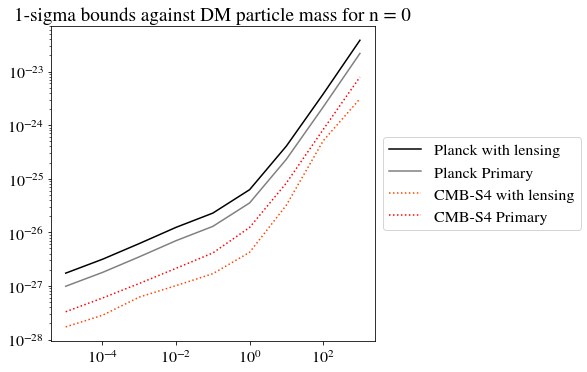

In [8]:
# plot settings fmos
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [5.8,5.8]
# plot it!
plt.figure(1)
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.xscale("log")
plt.yscale("log")
plt.plot(ls_of_mass, Planck_masses_inv, color = 'black', linestyle = '-', label = 'Planck with lensing')
plt.plot(ls_of_mass, Planck_masses_inv_linear, color = 'grey', linestyle = '-', label = 'Planck Primary')
# plt.plot(ls_of_mass, SO_masses_inv_linear, color = 'blue', linestyle = '--', label = 'Simons Observatory Primary')
# plt.plot(ls_of_mass, CMBS3_masses_inv, color = 'green', linestyle = '--', label = 'CMB-S3 with lensing')
plt.plot(ls_of_mass, CMBS4_masses_inv, color = 'orangered', linestyle = ':', label = 'CMB-S4 with lensing')
plt.plot(ls_of_mass, CMBS4_masses_inv_linear, color = 'red', linestyle = ':', label = 'CMB-S4 Primary')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("1-sigma bounds against DM particle mass for n = 0")
# plt.savefig('Li fig.3 for n = 0 with prepickled lensing.png',bbox_inches = 'tight')
         # , label = r'$\sigma_\mathrm{p}$')

NOW LOOK AT N = 2!

In [105]:
# for n = 2
Planck_n2 = []

Planck_n2.append(get_1_sigma(1e-5, "Planck", 2, 1e-25, 1e-25))
Planck_n2.append(get_1_sigma(1e-4, "Planck", 2, 1e-24, 1e-24))
Planck_n2.append(get_1_sigma(1e-3, "Planck", 2, 1e-21, 1e-21))
Planck_n2.append(get_1_sigma(1e-2, "Planck", 2, 1e-20, 1e-20))
Planck_n2.append(get_1_sigma(1e-1, "Planck", 2, 1e-19, 1e-19))
Planck_n2.append(get_1_sigma(1, "Planck", 2, 1e-18, 1e-18))
Planck_n2.append(get_1_sigma(10, "Planck", 2, 1e-17, 1e-17))
Planck_n2.append(get_1_sigma(100, "Planck", 2, 1e-15, 1e-15))
Planck_n2.append(get_1_sigma(1000, "Planck", 2, 1e-14, 1e-14))

Planck_n2_linear = []

Planck_n2_linear.append(get_1_sigma_linear(1e-5, "Planck", 2, 1e-25, 1e-25))
Planck_n2_linear.append(get_1_sigma_linear(1e-4, "Planck", 2, 1e-24, 1e-24))
Planck_n2_linear.append(get_1_sigma_linear(1e-3, "Planck", 2, 1e-21, 1e-21))
Planck_n2_linear.append(get_1_sigma_linear(1e-2, "Planck", 2, 1e-20, 1e-20))
Planck_n2_linear.append(get_1_sigma_linear(1e-1, "Planck", 2, 1e-19, 1e-19))
Planck_n2_linear.append(get_1_sigma_linear(1, "Planck", 2, 1e-18, 1e-18))
Planck_n2_linear.append(get_1_sigma_linear(10, "Planck", 2, 1e-17, 1e-17))
Planck_n2_linear.append(get_1_sigma_linear(100, "Planck", 2, 1e-15, 1e-15))
Planck_n2_linear.append(get_1_sigma_linear(1000, "Planck", 2, 1e-14, 1e-14))

In [107]:
S3_n2 = []

S3_n2.append(get_1_sigma_updated(1e-5, "S3", 2, 1e-25, 1e-25))
S3_n2.append(get_1_sigma_updated(1e-4, "S3", 2, 1e-24, 1e-24))
S3_n2.append(get_1_sigma_updated(1e-3, "S3", 2, 1e-21, 1e-21))
S3_n2.append(get_1_sigma_updated(1e-2, "S3", 2, 1e-20, 1e-20))
S3_n2.append(get_1_sigma_updated(1e-1, "S3", 2, 1e-19, 1e-19))
S3_n2.append(get_1_sigma_updated(1, "S3", 2, 1e-18, 1e-18))
S3_n2.append(get_1_sigma_updated(10, "S3", 2, 1e-17, 1e-17))
S3_n2.append(get_1_sigma_updated(100, "S3", 2, 1e-15, 1e-15))
S3_n2.append(get_1_sigma_updated(1000, "S3", 2, 1e-14, 1e-14))

In [110]:
S4_n2 = []

S4_n2.append(get_1_sigma_updated(1e-5, "S4", 2, 1e-25, 1e-25))
S4_n2.append(get_1_sigma_updated(1e-4, "S4", 2, 1e-24, 1e-24))
S4_n2.append(get_1_sigma_updated(1e-3, "S4", 2, 1e-21, 1e-21))
S4_n2.append(get_1_sigma_updated(1e-2, "S4", 2, 1e-20, 1e-20))
S4_n2.append(get_1_sigma_updated(1e-1, "S4", 2, 1e-19, 1e-19))
S4_n2.append(get_1_sigma_updated(1, "S4", 2, 1e-18, 1e-18))
S4_n2.append(get_1_sigma_updated(10, "S4", 2, 1e-17, 1e-17))
S4_n2.append(get_1_sigma_updated(100, "S4", 2, 1e-15, 1e-15))
S4_n2.append(get_1_sigma_updated(1000, "S4", 2, 1e-14, 1e-14))

Text(0.5, 1.0, '1-sigma bounds against DM particle mass for n = 2')

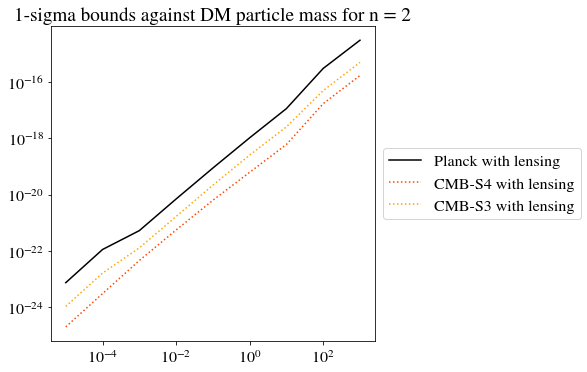

In [160]:
# plot it for n = 2!
plt.figure(2)
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.xscale("log")
plt.yscale("log")
plt.plot(ls_of_mass, Planck_n2, color = 'black', linestyle = '-', label = 'Planck with lensing')
# plt.plot(ls_of_mass, SO_masses_inv, color = 'blue', linestyle = '--', label = 'Simons Observatory')
plt.plot(ls_of_mass, S4_n2, color = 'orangered', linestyle = ':', label = 'CMB-S4 with lensing')
plt.plot(ls_of_mass, S3_n2, color = 'orange', linestyle = ':', label = 'CMB-S3 with lensing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("1-sigma bounds against DM particle mass for n = 2")
# plt.savefig('Li fig.3 for n = 2 with prepickled lensing.png',bbox_inches = 'tight')
         # , label = r'$\sigma_\mathrm{p}$')

In [113]:
# for Planck in model n = 4!
Planck_n4 = []

Planck_n4.append(get_1_sigma_updated(1e-5, "Planck", 4, 1e-25, 1e-25))
Planck_n4.append(get_1_sigma_updated(1e-4, "Planck", 4, 1e-23, 1e-23))
Planck_n4.append(get_1_sigma_updated(1e-3, "Planck", 4, 1e-16, 1e-16))
Planck_n4.append(get_1_sigma_updated(1e-2, "Planck", 4, 1e-14, 1e-14))
Planck_n4.append(get_1_sigma_updated(1e-1, "Planck", 4, 1e-12, 1e-12))
Planck_n4.append(get_1_sigma_updated(1, "Planck", 4, 1e-11, 1e-11))
Planck_n4.append(get_1_sigma_updated(10, "Planck", 4, 1e-9, 1e-9))
Planck_n4.append(get_1_sigma_updated(100, "Planck", 4, 1e-7, 1e-7))
Planck_n4.append(get_1_sigma_updated(1000, "Planck", 4, 1e-6, 1e-6))

Planck_n4_linear = []

Planck_n4_linear.append(get_1_sigma_linear(1e-5, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(1e-4, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(1e-3, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(1e-2, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(1e-1, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(1, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(10, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(100, Planck_assumption))
Planck_n4_linear.append(get_1_sigma_linear(1000, Planck_assumption))

In [115]:
# S3 and S4!
S3_n4 = []

S3_n4.append(get_1_sigma_updated(1e-5, "S3", 4, 1e-25, 1e-25))
S3_n4.append(get_1_sigma_updated(1e-4, "S3", 4, 1e-23, 1e-23))
S3_n4.append(get_1_sigma_updated(1e-3, "S3", 4, 1e-16, 1e-16))
S3_n4.append(get_1_sigma_updated(1e-2, "S3", 4, 1e-14, 1e-14))
S3_n4.append(get_1_sigma_updated(1e-1, "S3", 4, 1e-12, 1e-12))
S3_n4.append(get_1_sigma_updated(1, "S3", 4, 1e-11, 1e-11))
S3_n4.append(get_1_sigma_updated(10, "S3", 4, 1e-9, 1e-9))
S3_n4.append(get_1_sigma_updated(100, "S3", 4, 1e-7, 1e-7))
S3_n4.append(get_1_sigma_updated(1000, "S3", 4, 1e-6, 1e-6))

S4_n4 = []

S4_n4.append(get_1_sigma_updated(1e-5, "S4", 4, 1e-25, 1e-25))
S4_n4.append(get_1_sigma_updated(1e-4, "S4", 4, 1e-23, 1e-23))
S4_n4.append(get_1_sigma_updated(1e-3, "S4", 4, 1e-16, 1e-16))
S4_n4.append(get_1_sigma_updated(1e-2, "S4", 4, 1e-14, 1e-14))
S4_n4.append(get_1_sigma_updated(1e-1, "S4", 4, 1e-12, 1e-12))
S4_n4.append(get_1_sigma_updated(1, "S4", 4, 1e-11, 1e-11))
S4_n4.append(get_1_sigma_updated(10, "S4", 4, 1e-9, 1e-9))
S4_n4.append(get_1_sigma_updated(100, "S4", 4, 1e-7, 1e-7))
S4_n4.append(get_1_sigma_updated(1000, "S4", 4, 1e-6, 1e-6))

Text(0.5, 1.0, '1-sigma bounds against DM particle mass for n = 4')

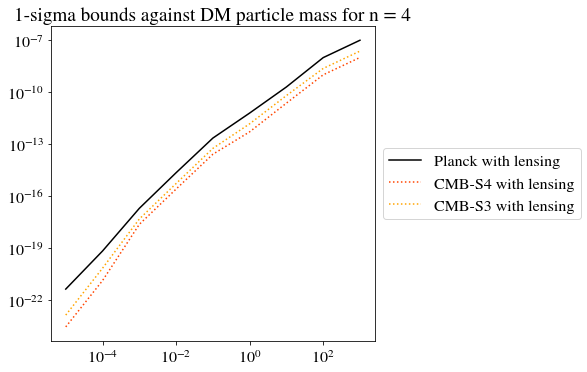

In [161]:
# plot it for n = 4!
plt.figure(3)
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.xscale("log")
plt.yscale("log")
plt.plot(ls_of_mass, Planck_n4, color = 'black', linestyle = '-', label = 'Planck with lensing')
# plt.plot(ls_of_mass, SO_masses_inv, color = 'blue', linestyle = '--', label = 'Simons Observatory')
plt.plot(ls_of_mass, S4_n4, color = 'orangered', linestyle = ':', label = 'CMB-S4 with lensing')
plt.plot(ls_of_mass, S3_n4, color = 'orange', linestyle = ':', label = 'CMB-S3 with lensing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("1-sigma bounds against DM particle mass for n = 4")
# plt.savefig('Li fig.3 for n = 4 with prepickled lensing.png',bbox_inches = 'tight')
         # , label = r'$\sigma_\mathrm{p}$')

n = 6!

In [136]:
# for Planck in model n = 6
Planck_n6 = []

Planck_n6.append(get_1_sigma_updated(1e-5, "Planck", 6, 1e-24, 1e-24))
Planck_n6.append(get_1_sigma_updated(1e-4, "Planck", 6, 1e-21, 1e-21))
Planck_n6.append(get_1_sigma_updated(1e-3, "Planck", 6, 1e-12, 1e-12))
Planck_n6.append(get_1_sigma_updated(1e-2, "Planck", 6, 1e-9, 1e-9))
Planck_n6.append(get_1_sigma_updated(1e-1, "Planck", 6, 1e-6, 1e-6))
Planck_n6.append(get_1_sigma_updated(1, "Planck", 6, 1e-4, 1e-4))
Planck_n6.append(get_1_sigma_updated(10, "Planck", 6, 1e-3, 1e-3))
Planck_n6.append(get_1_sigma_updated(100, "Planck", 6, 1e-1, 1e-1))
Planck_n6.append(get_1_sigma_updated(1000, "Planck", 6, 1e-1, 1e-1))

Planck_n6_linear = []

Planck_n6_linear.append(get_1_sigma_linear(1e-5, Planck_assumption, 6, 1e-24, 1e-24))
Planck_n6_linear.append(get_1_sigma_linear(1e-4, Planck_assumption, 6, 1e-21, 1e-21))
Planck_n6_linear.append(get_1_sigma_linear(1e-3, Planck_assumption, 6, 1e-12, 1e-12))
Planck_n6_linear.append(get_1_sigma_linear(1e-2, Planck_assumption, 6, 1e-9, 1e-9))
Planck_n6_linear.append(get_1_sigma_linear(1e-1, Planck_assumption, 6, 1e-6, 1e-6))
Planck_n6_linear.append(get_1_sigma_linear(1, Planck_assumption, 6, 1e-4, 1e-4))
Planck_n6_linear.append(get_1_sigma_linear(10, Planck_assumption, 6, 1e-3, 1e-3))
Planck_n6_linear.append(get_1_sigma_linear(100, Planck_assumption, 6, 1e-1, 1e-1))
Planck_n6_linear.append(get_1_sigma_linear(1000, Planck_assumption, 6, 1e-1, 1e-1))

In [144]:
print(Planck_n6_linear)

[2.0286205666699895e-21, 4.903384778441741e-18, 1.983336173905553e-13, 2.119087466439565e-10, 1.7862565853853765e-07, 2.318589148656709e-05, 0.00034873397011324445, 0.010379294515048291, 0.03677395778149918]


In [142]:
# S3 and S4 for n = 6
S3_n6 = []
S4_n6 = []

S3_n6.append(get_1_sigma_updated(1e-5, "S3", 6, 1e-24, 1e-24))
S3_n6.append(get_1_sigma_updated(1e-4, "S3", 6, 1e-21, 1e-21))
S3_n6.append(get_1_sigma_updated(1e-3, "S3", 6, 1e-12, 1e-12))
S3_n6.append(get_1_sigma_updated(1e-2, "S3", 6, 1e-9, 1e-9))
S3_n6.append(get_1_sigma_updated(1e-1, "S3", 6, 1e-6, 1e-6))
S3_n6.append(get_1_sigma_updated(1, "S3", 6, 1e-4, 1e-4))
S3_n6.append(get_1_sigma_updated(10, "S3", 6, 1e-3, 1e-3))
S3_n6.append(get_1_sigma_updated(100, "S3", 6, 1e-1, 1e-1))
S3_n6.append(get_1_sigma_updated(1000, "S3", 6, 1e-1, 1e-1))

S4_n6.append(get_1_sigma_updated(1e-5, "S4", 6, 1e-24, 1e-24))
S4_n6.append(get_1_sigma_updated(1e-4, "S4", 6, 1e-21, 1e-21))
S4_n6.append(get_1_sigma_updated(1e-3, "S4", 6, 1e-12, 1e-12))
S4_n6.append(get_1_sigma_updated(1e-2, "S4", 6, 1e-9, 1e-9))
S4_n6.append(get_1_sigma_updated(1e-1, "S4", 6, 1e-6, 1e-6))
S4_n6.append(get_1_sigma_updated(1, "S4", 6, 1e-4, 1e-4))
S4_n6.append(get_1_sigma_updated(10, "S4", 6, 1e-3, 1e-3))
S4_n6.append(get_1_sigma_updated(100, "S4", 6, 1e-1, 1e-1))
S4_n6.append(get_1_sigma_updated(1000, "S4", 6, 1e-1, 1e-1))

In [153]:
S4_n6_linear = []

S4_n6_linear.append(get_1_sigma_linear(1e-5, CMBS4_assumption, 6, 1e-24, 1e-24))
S4_n6_linear.append(get_1_sigma_linear(1e-4, CMBS4_assumption, 6, 1e-21, 1e-21))
S4_n6_linear.append(get_1_sigma_linear(1e-3, CMBS4_assumption, 6, 1e-12, 1e-12))
S4_n6_linear.append(get_1_sigma_linear(1e-2, CMBS4_assumption, 6, 1e-9, 1e-9))
S4_n6_linear.append(get_1_sigma_linear(1e-1, CMBS4_assumption, 6, 1e-6, 1e-6))
S4_n6_linear.append(get_1_sigma_linear(1, CMBS4_assumption, 6, 1e-4, 1e-4))
S4_n6_linear.append(get_1_sigma_linear(10, CMBS4_assumption, 6, 1e-3, 1e-3))
S4_n6_linear.append(get_1_sigma_linear(100, CMBS4_assumption, 6, 1e-1, 1e-1))
S4_n6_linear.append(get_1_sigma_linear(1000, CMBS4_assumption, 6, 1e-1, 1e-1))

Text(0.5, 1.0, '1-sigma bounds against DM particle mass for n = 6')

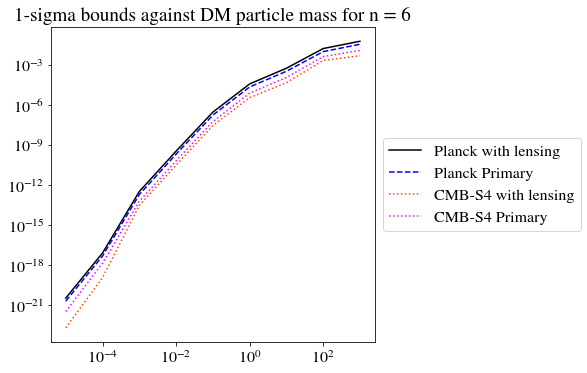

In [162]:
# plot it for n = 6!
plt.figure(4)
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.xscale("log")
plt.yscale("log")
plt.plot(ls_of_mass, Planck_n6, color = 'black', linestyle = '-', label = 'Planck with lensing')
plt.plot(ls_of_mass, Planck_n6_linear, color = 'blue', linestyle = '--', label = 'Planck Primary')
plt.plot(ls_of_mass, S4_n6, color = 'orangered', linestyle = ':', label = 'CMB-S4 with lensing')
plt.plot(ls_of_mass, S4_n6_linear, color = 'magenta', linestyle = ':', label = 'CMB-S4 Primary')
# plt.plot(ls_of_mass, S3_n6, color = 'orange', linestyle = ':', label = 'CMB-S3 with lensing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("1-sigma bounds against DM particle mass for n = 6")
# plt.savefig('Li fig.3 for n = 6 with prepickled lensing.png',bbox_inches = 'tight')
         # , label = r'$\sigma_\mathrm{p}$')

Now, of course, we get to n = -2

In [132]:
# for Planck in model n = -2
Planck_nm2 = []

Planck_nm2.append(get_1_sigma_updated(1e-5, "Planck", -2, 1e-33, 1e-33))
Planck_nm2.append(get_1_sigma_updated(1e-4, "Planck", -2, 1e-33, 1e-33))
Planck_nm2.append(get_1_sigma_updated(1e-3, "Planck", -2, 1e-33, 1e-33))
Planck_nm2.append(get_1_sigma_updated(1e-2, "Planck", -2, 1e-33, 1e-33))
Planck_nm2.append(get_1_sigma_updated(1e-1, "Planck", -2, 1e-33, 1e-33))
Planck_nm2.append(get_1_sigma_updated(1, "Planck", -2, 1e-33, 1e-33))
Planck_nm2.append(get_1_sigma_updated(10, "Planck", -2, 1e-32, 1e-32))
Planck_nm2.append(get_1_sigma_updated(100, "Planck", -2, 1e-31, 1e-31))
Planck_nm2.append(get_1_sigma_updated(1000, "Planck", -2, 1e-31, 1e-31))

Planck_nm2_linear = []

Planck_nm2_linear.append(get_1_sigma_linear(1e-5, Planck_assumption, -2, 1e-33, 1e-33))
Planck_nm2_linear.append(get_1_sigma_linear(1e-4, Planck_assumption, -2, 1e-33, 1e-33))
Planck_nm2_linear.append(get_1_sigma_linear(1e-3, Planck_assumption, -2, 1e-33, 1e-33))
Planck_nm2_linear.append(get_1_sigma_linear(1e-2, Planck_assumption, -2, 1e-33, 1e-33))
Planck_nm2_linear.append(get_1_sigma_linear(1e-1, Planck_assumption, -2, 1e-33, 1e-33))
Planck_nm2_linear.append(get_1_sigma_linear(1, Planck_assumption, -2, 1e-33, 1e-33))
Planck_nm2_linear.append(get_1_sigma_linear(10, Planck_assumption, -2, 1e-32, 1e-32))
Planck_nm2_linear.append(get_1_sigma_linear(100, Planck_assumption, -2, 1e-31, 1e-31))
Planck_nm2_linear.append(get_1_sigma_linear(1000, Planck_assumption, -2, 1e-31, 1e-31))

In [133]:
# S3 and S4 for n = -2
S3_nm2 = []
S4_nm2 = []

S3_nm2.append(get_1_sigma_updated(1e-5, "S3", -2, 1e-33, 1e-33))
S3_nm2.append(get_1_sigma_updated(1e-4, "S3", -2, 1e-33, 1e-33))
S3_nm2.append(get_1_sigma_updated(1e-3, "S3", -2, 1e-33, 1e-33))
S3_nm2.append(get_1_sigma_updated(1e-2, "S3", -2, 1e-33, 1e-33))
S3_nm2.append(get_1_sigma_updated(1e-1, "S3", -2, 1e-33, 1e-33))
S3_nm2.append(get_1_sigma_updated(1, "S3", -2, 1e-33, 1e-33))
S3_nm2.append(get_1_sigma_updated(10, "S3", -2, 1e-32, 1e-32))
S3_nm2.append(get_1_sigma_updated(100, "S3", -2, 1e-31, 1e-31))
S3_nm2.append(get_1_sigma_updated(1000, "S3", -2, 1e-31, 1e-31))

S4_nm2.append(get_1_sigma_updated(1e-5, "S4", -2, 1e-33, 1e-33))
S4_nm2.append(get_1_sigma_updated(1e-4, "S4", -2, 1e-33, 1e-33))
S4_nm2.append(get_1_sigma_updated(1e-3, "S4", -2, 1e-33, 1e-33))
S4_nm2.append(get_1_sigma_updated(1e-2, "S4", -2, 1e-33, 1e-33))
S4_nm2.append(get_1_sigma_updated(1e-1, "S4", -2, 1e-33, 1e-33))
S4_nm2.append(get_1_sigma_updated(1, "S4", -2, 1e-33, 1e-33))
S4_nm2.append(get_1_sigma_updated(10, "S4", -2, 1e-32, 1e-32))
S4_nm2.append(get_1_sigma_updated(100, "S4", -2, 1e-31, 1e-31))
S4_nm2.append(get_1_sigma_updated(1000, "S4", -2, 1e-31, 1e-31))

Text(0.5, 1.0, '1-sigma bounds against DM particle mass for n = -2')

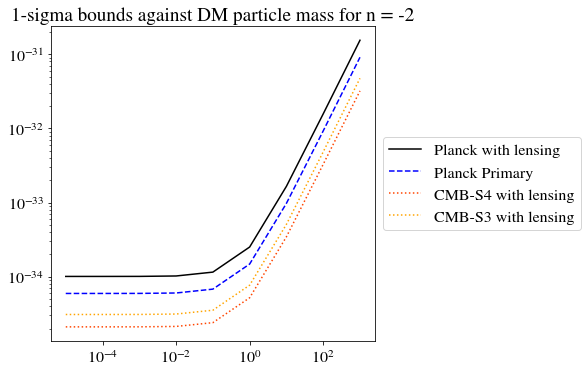

In [163]:
# plot it for n = -2!
plt.figure(5)
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.xscale("log")
plt.yscale("log")
plt.plot(ls_of_mass, Planck_nm2, color = 'black', linestyle = '-', label = 'Planck with lensing')
plt.plot(ls_of_mass, Planck_nm2_linear, color = 'blue', linestyle = '--', label = 'Planck Primary')
plt.plot(ls_of_mass, S4_nm2, color = 'orangered', linestyle = ':', label = 'CMB-S4 with lensing')
plt.plot(ls_of_mass, S3_nm2, color = 'orange', linestyle = ':', label = 'CMB-S3 with lensing')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("1-sigma bounds against DM particle mass for n = -2")
# plt.savefig('Li fig.3 for n = -2 with prepickled lensing.png',bbox_inches = 'tight')
         # , label = r'$\sigma_\mathrm{p}$')